In [1]:
# 动手学深度学习-Day2

In [2]:
#优化方法

$梯度下降（很少直接使用这个方法，每次计算梯度都要对损失函数进行求导，而整个损失函数与整体样本数相关，计算成本太高）$\
$小批量随机梯度下降（随机采样一定样本，用来近似损失,批量batch \quad size和学习率learning \quad rate需要考量）$

In [3]:
# 线性回归
# Deep Learning基础

$问题来源：美国房价$\
$假设1：影响房价的关键因素是卧室个数，卫生间个数和居住面积，记x_1,x_2,x_3$\
$假设2：成交价是关键因素的加权和，记y=w_1x_1+w_2x_2+w_3x_3+b，权重w_i和偏差b的实际值在后面决定$\
$向量版本：y=\langle \textbf{w},\textbf{x} \rangle+b$

$评估函数，y是真实值，\hat{y}是预测值，定义l(y,\hat{y})=\frac {1}{2}(y-\hat{y})^2为平方损失$

$数据集：\textbf{X}=[x_1,x_2,\ldots,x_n]^T,\textbf{y}=[y_1,y_2,\ldots,y_n]^T$\
$训练损失函数：l(\textbf{X},\textbf{y},\textbf{w},b)=\frac {1}{2n}\displaystyle\sum_{i=1}^{n}(y_{i}-\langle \textbf x_{i},\textbf{w} \rangle-b)^2=\frac {1}{2n}\Vert\textbf{y}-\textbf{X}\textbf{w}-b \Vert^2$\
$最小化损失来学习参数：\textbf{w}^*,b^*=arg\mathop{\min}_{\textbf{w},b}l(\textbf{X},\textbf{y},\textbf{w},b)$

In [4]:
%matplotlib inline
import random
import torch
import pandas as pd
from d2l import torch as d2l
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
# 随机生成数据集，在实际计算过程中可以运用自己的数据噢
def data(w,b,num_examples):
    x = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(x,w) + b
    y += torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = data(true_w,true_b,1000)
features,labels

(tensor([[-0.3610, -0.4082],
         [-0.5476,  0.9421],
         [-1.7698,  1.7071],
         ...,
         [-0.4981, -0.4184],
         [-0.9297,  0.8565],
         [ 0.4680, -0.9594]]),
 tensor([[ 4.8440e+00],
         [-1.0547e-01],
         [-5.1420e+00],
         [ 3.5400e+00],
         [ 4.8718e+00],
         [ 6.7850e+00],
         [-1.2459e+00],
         [ 3.5224e+00],
         [ 7.2361e+00],
         [-5.3809e-01],
         [ 3.8198e+00],
         [ 3.2983e-01],
         [ 6.4176e+00],
         [-3.5394e+00],
         [ 5.3226e+00],
         [ 8.1694e+00],
         [ 3.2723e+00],
         [ 1.0298e+00],
         [ 7.9228e-01],
         [ 8.5880e+00],
         [ 1.0829e+01],
         [ 2.0103e+00],
         [ 4.8947e+00],
         [ 5.3366e+00],
         [ 4.5759e+00],
         [ 4.9093e+00],
         [ 6.5523e+00],
         [ 1.0728e+01],
         [ 4.4936e+00],
         [ 1.5593e+00],
         [ 6.1416e+00],
         [ 5.7672e+00],
         [-4.1906e-01],
         [ 2.4891e

In [6]:
print('features',features[2],'\nlabel',labels[2])

features tensor([-1.7698,  1.7071]) 
label tensor([-5.1420])


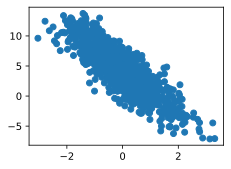

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy())

In [8]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #shuffle打乱样本
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
        
batch_size = 10
    
for x,y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    break

tensor([[ 1.1235, -1.0005],
        [ 0.3604,  1.1849],
        [-1.4179, -0.2053],
        [-0.4031, -2.1225],
        [ 1.2459, -1.8599],
        [-0.6246, -1.1953],
        [ 1.0332,  0.0564],
        [ 0.2021,  0.5313],
        [-1.3811, -1.2930],
        [ 0.4529,  0.3930]]) 
 tensor([[ 9.8499],
        [ 0.8793],
        [ 2.0609],
        [10.6185],
        [13.0117],
        [ 7.0222],
        [ 6.0832],
        [ 2.7923],
        [ 5.8303],
        [ 3.7778]])


In [9]:
# 定义初始化模型参数
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [10]:
# 定义线性回归模型
def linreg(x,w,b):
    return torch.matmul(x,w)+b
# 定义损失函数
def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape))**2/2
# 定义优化方法
def sgd(params, lr, batch_size):  
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)#小批量损失
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041726
epoch 2, loss 0.000153
epoch 3, loss 0.000047


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001, -0.0007], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


In [13]:
# 案例实现
# 页岩气井采收率线性回归

In [14]:
## 数据读取
data = pd.read_csv('Chapter6_Shale Gas Wells.csv')
data.describe()

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading,EUR
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,147.640316,35.134387,820.158103,0.069170,162.365613,8153.086957,63.079051,7.337549,7010.490119,19.213439,64.845455,0.930257,2567.065217,12.845455
std,18.392128,10.533197,135.736986,0.253994,15.471044,942.393981,7.250106,0.749451,1211.452205,3.198579,18.427813,0.046507,413.792220,3.067064
min,140.000000,30.000000,650.000000,0.000000,120.000000,4500.000000,55.000000,5.500000,5000.000000,15.000000,15.000000,0.750000,1100.000000,7.000000
25%,140.000000,30.000000,700.000000,0.000000,153.000000,7617.750000,57.000000,6.600000,5000.000000,16.800000,55.900000,0.940000,2317.500000,11.000000
50%,141.000000,30.000000,800.000000,0.000000,165.000000,8051.000000,61.000000,7.500000,7643.000000,17.700000,69.900000,0.950000,2642.000000,12.400000
75%,148.000000,36.000000,900.000000,0.000000,176.000000,8608.000000,69.000000,8.000000,7783.000000,24.100000,79.700000,0.950000,2897.750000,13.700000
max,330.000000,75.000000,1350.000000,1.000000,185.000000,11500.000000,80.000000,8.500000,8200.000000,25.000000,95.000000,0.950000,3200.000000,22.000000


In [15]:
features_1 = torch.tensor([data.iloc[:,0:13].values])
labels_1 = torch.tensor([data.iloc[:,13].values])
features_1,labels_1

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21116\3404879193.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  features_1 = torch.tensor([data.iloc[:,0:13].values])


(tensor([[[1.4000e+02, 3.8000e+01, 8.5000e+02,  ..., 3.8000e+01,
           9.5000e-01, 3.0120e+03],
          [1.4000e+02, 3.0000e+01, 9.0000e+02,  ..., 5.9300e+01,
           9.5000e-01, 2.7710e+03],
          [1.4000e+02, 3.0000e+01, 9.0000e+02,  ..., 5.9300e+01,
           9.5000e-01, 3.0670e+03],
          ...,
          [1.4000e+02, 3.0000e+01, 7.0000e+02,  ..., 8.6500e+01,
           9.5000e-01, 2.9730e+03],
          [1.4000e+02, 3.0000e+01, 7.5000e+02,  ..., 8.6500e+01,
           9.5000e-01, 2.9250e+03],
          [1.4000e+02, 3.0000e+01, 7.5000e+02,  ..., 8.6500e+01,
           9.5000e-01, 2.8440e+03]]], dtype=torch.float64),
 tensor([[13.3000, 12.5000, 16.9000, 16.5000, 17.4000, 14.9000, 13.0000, 14.4000,
          10.8000, 11.6000, 10.3000, 11.6000, 12.6000, 12.1000, 11.4000, 12.0000,
          13.0000, 11.2000, 12.1000, 11.4000,  9.9000, 11.9000, 10.4000, 10.2000,
          10.5000, 10.0000, 10.9000, 10.3000, 11.5000, 12.3000,  9.6000, 10.2000,
           9.7000,  9.7000,

In [16]:
# 归一化一下噢
# 找到 features_1 中的最小值和最大值
min_val = torch.min(features_1)
max_val = torch.max(features_1)
# 进行最大最小归一化
features_1 = (features_1 - min_val) / (max_val - min_val)
# 找到 labels_1 中的最小值和最大值
min_val = torch.min(labels_1)
max_val = torch.max(labels_1)
# 进行最大最小归一化
labels_1 = (labels_1 - min_val) / (max_val - min_val)

In [17]:
def data_iter_1(batch_size_1,features_1,labels_1):
    num_examples_1 = len(features_1)
    indices_1 = list(range(num_examples_1))
    #shuffle打乱样本
    random.shuffle(indices_1)
    for i in range(0,num_examples_1,batch_size_1):
        batch_indices_1 = torch.tensor(indices_1[i:min(i+batch_size_1,num_examples_1)])
        yield features_1[batch_indices_1],labels_1[batch_indices_1]
        
batch_size_1 = 100

for X,Y in data_iter_1(batch_size_1,features_1,labels_1):
    break

In [18]:
# 定义初始化模型参数
W = torch.normal(-1,1,size=(13,1),requires_grad=True)
B = torch.zeros(1,requires_grad=True)

In [19]:
# 定义线性回归模型
def linreg(X,W,B):
    return torch.matmul(X,W)+B
# 定义损失函数
def squared_loss(Y_hat,Y):
    return (Y_hat - Y.reshape(Y_hat.shape))**2/2
# 定义优化方法
def sgd(params, lr, batch_size_1):  
    with torch.no_grad():
        for param in params:
            if param.grad is not None:
                param -= lr * param.grad/batch_size_1
                param.grad.zero_()

In [20]:
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,Y in data_iter_1(batch_size_1,features_1,labels_1):
        X = X.double()
        W = W.double()
        B = B.double()
        l = loss(net(X,W,B),Y)#小批量损失
        l.sum().backward()
        sgd([W,B],lr,batch_size_1)
    with torch.no_grad():
        train_l = loss(net(features_1,W,B),labels_1)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.053165
epoch 2, loss 0.053165
epoch 3, loss 0.053165
epoch 4, loss 0.053165
epoch 5, loss 0.053165
epoch 6, loss 0.053165
epoch 7, loss 0.053165
epoch 8, loss 0.053165
epoch 9, loss 0.053165
epoch 10, loss 0.053165


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21116\1729163784.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:485.)
  if param.grad is not None:
